In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras


In [2]:
!git clone https://github.com/dduygaucho/asl.git

Cloning into 'asl'...
remote: Enumerating objects: 87035, done.
remote: Total 87035 (delta 0), reused 0 (delta 0), pack-reused 87035
Receiving objects: 100% (87035/87035), 1.01 GiB | 31.19 MiB/s, done.
Checking out files: 100% (87028/87028), done.


In [3]:
import os 
def create_dataset(link):
  master = {}
  master['label'] = []
  master['filepath'] = []

  for folder in os.listdir(link):
    filepath = link + '/' + folder
    for sub in os.listdir(filepath):
      new_file = filepath + '/'+ sub
      master['filepath'].append(new_file)
      master['label'].append(folder)
  
  df = pd.DataFrame.from_dict(master)
  return df 

def create_dataset_test(link):
    master = {}
    master['label'] = []
    master['filepath'] = []
    for sub in os.listdir(link):
        new_file = link + '/' + sub
        master['label'].append(sub.split('.')[0].split('_')[0])
        master['filepath'].append(new_file)

    df = pd.DataFrame.from_dict(master)
    return df

train_df = create_dataset('/content/asl/asl_alphabet_train/asl_alphabet_train')  
test_df = create_dataset_test('/content/asl/asl_alphabet_test/asl_alphabet_test')

In [4]:
len(train_df)

87000

In [5]:
train_df['filepath'].unique()

array(['/content/asl/asl_alphabet_train/asl_alphabet_train/I/I652.jpg',
       '/content/asl/asl_alphabet_train/asl_alphabet_train/I/I1736.jpg',
       '/content/asl/asl_alphabet_train/asl_alphabet_train/I/I2677.jpg',
       ...,
       '/content/asl/asl_alphabet_train/asl_alphabet_train/S/S2922.jpg',
       '/content/asl/asl_alphabet_train/asl_alphabet_train/S/S683.jpg',
       '/content/asl/asl_alphabet_train/asl_alphabet_train/S/S2216.jpg'],
      dtype=object)

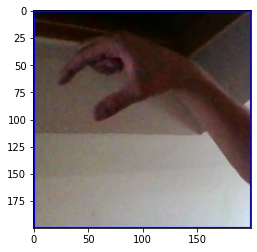

In [6]:
# Visualising an example, use cv2 to extract information and plt.imshow to display
import cv2
image = cv2.imread('/content/asl/asl_alphabet_train/asl_alphabet_train/Q/Q2404.jpg')
image = cv2.cvtColor(image,  cv2.COLOR_BGR2RGB)
plt.imshow(image)

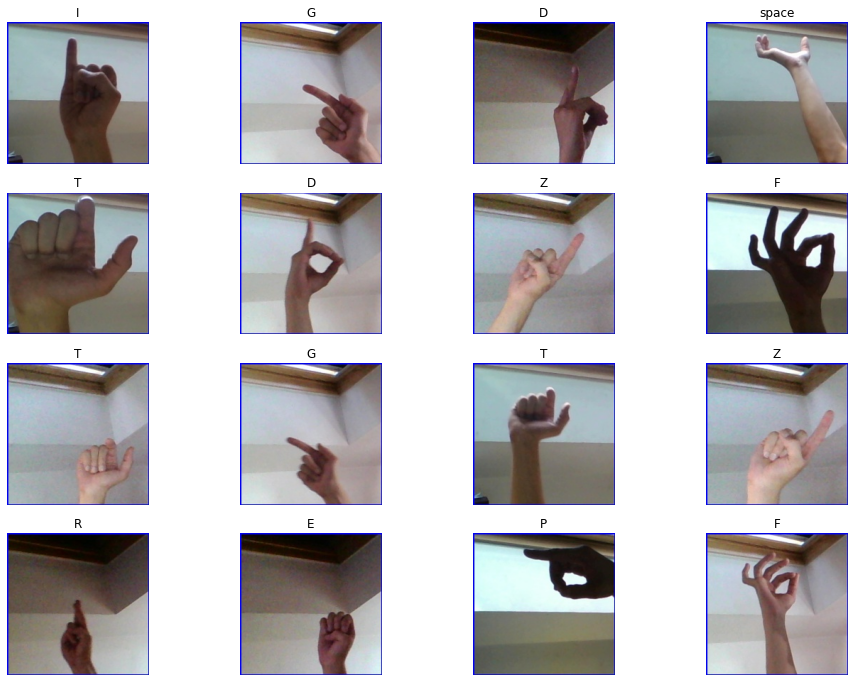

In [7]:
def plot_several_images(df):
  plot_images = df.sample(n = 16)
  plt.figure(figsize = (16,12))
  n_row = 4
  # fig, axs = plt.subplots(n_row, n_row)
  for row in range(n_row):
    for col in range(n_row):
      ind = n_row*row+col
      path = plot_images.iloc[ind]['filepath']

      image = cv2.imread(path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      plt.subplot(4, 4, ind+1)
      plt.imshow(image)
      plt.title(plot_images.iloc[ind]['label'])
      plt.axis('off')

plot_several_images(train_df)

In [8]:
# Summary of dataset
def summary(df):
  return df[['label']].value_counts()

classes = len(summary(train_df))
summary(train_df)
# fairly equal

label  
A          3000
P          3000
nothing    3000
del        3000
Z          3000
Y          3000
X          3000
W          3000
V          3000
U          3000
T          3000
S          3000
R          3000
Q          3000
O          3000
B          3000
N          3000
M          3000
L          3000
K          3000
J          3000
I          3000
H          3000
G          3000
F          3000
E          3000
D          3000
C          3000
space      3000
dtype: int64

# Building own CNN

## Preparing dataset for own CNN


In [9]:
from sklearn.model_selection import train_test_split

training_df, val_df = train_test_split(train_df, test_size = 0.2, random_state= 42, stratify = train_df[['label']])

In [10]:
print(len(training_df), len(val_df))

69600 17400


In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    # validation_split = 0.2,
    horizontal_flip = True,
    zoom_range = 0.2
)

train_images = train_generator.flow_from_dataframe(
    dataframe = training_df,
    x_col = 'filepath', y_col = 'label', 
    target_size = (224,224),
    batch_size = 32, 
    shuffle = True, 
    class_mode = 'categorical'
)


val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    # validation_split = 0.2,
    horizontal_flip = True,
    zoom_range = 0.2
)

val_images = val_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepath', y_col = 'label', 
    target_size = (224,224),
    batch_size = 32, 
    shuffle = True, 
    class_mode = 'categorical'
)



Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (8,8), input_shape = (224,224,3), padding = 'SAME'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (3,3)))


model.add(Conv2D(filters = 64, kernel_size = (6,6), input_shape = (224,224,3), padding = 'SAME'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (3,3)))


model.add(Conv2D(filters = 128, kernel_size = (5,5), input_shape = (224,224,3), padding = 'SAME'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (3,3)))


model.add(Conv2D(filters = 256, kernel_size = (6,6), input_shape = (224,224,3), padding = 'SAME'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

model.add(Flatten())
model.add(keras.layers.BatchNormalization())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(classes ,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      6176      
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 74, 74, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                    

# Build an XCeption model

In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input,
    validation_split = 0.2,
    horizontal_flip = True,
    zoom_range = 0.2
)

train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepath', y_col = 'label', 
    color_mode = 'rgb',
    target_size = (224,224),
    batch_size = 32, 
    shuffle = True, 
    class_mode = 'categorical'
)


val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input,
    validation_split = 0.2,
    horizontal_flip = True,
    zoom_range = 0.2
)

val_images = val_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepath', y_col = 'label', 
    target_size = (224,224),
    batch_size = 32, 
    shuffle = True, 
    class_mode = 'categorical'
)

Found 87000 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


In [17]:
# Neural network architecture

pretrainedModel = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

17235968/17225924 [==============================] - 0s 0us/step


In [18]:
# Compile model
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Fit model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
 )

Epoch 1/2
2719/2719 [==============================] - 1104s 402ms/step - loss: 0.2390 - accuracy: 0.9238 - val_loss: 0.1000 - val_accuracy: 0.9672
Epoch 2/2
2719/2719 [==============================] - 1090s 401ms/step - loss: 0.1270 - accuracy: 0.9641 - val_loss: 0.1081 - val_accuracy: 0.9716


# Evaluation on test set

In [ ]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input,
    validation_split = 0.2,
    horizontal_flip = True,
    zoom_range = 0.2
)

test_images =test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepath', y_col = 'label', 
    target_size = (224,224),
    batch_size = 32, 
    shuffle = True, 
    class_mode = 'categorical'
)

model.evaluate(test_images)

In [ ]:
train_df.shape

(87000, 2)

In [ ]:
len(train_images)

2719

In [ ]:
model.predict(train_images[0][0])

array([[3.78116566e-15, 2.17784716e-20, 1.15461751e-21, 7.58042823e-23,
        5.34808092e-13, 6.17104696e-18, 9.76431799e-14, 6.05956849e-17,
        1.06598144e-08, 1.00000000e+00, 9.77844125e-11, 1.65514302e-22,
        1.24474734e-16, 1.20522762e-15, 4.39690017e-15, 4.95901896e-22,
        7.32036843e-17, 2.39354088e-12, 8.39514680e-10, 2.53905286e-19,
        2.83634731e-18, 2.18103818e-14, 1.63033825e-17, 1.50570084e-10,
        1.69366149e-13, 2.36502467e-11, 2.81494829e-20, 9.71366009e-22,
        1.54706386e-16],
       [6.66976413e-12, 1.88565903e-15, 2.87544714e-14, 1.07467346e-09,
        4.47597878e-13, 1.00000000e+00, 4.93621833e-15, 2.08051594e-16,
        3.63613675e-12, 1.10029471e-21, 4.84315652e-14, 1.83295610e-12,
        1.45255238e-21, 3.35705767e-27, 1.74889931e-15, 4.47997546e-17,
        7.79989297e-18, 9.40813386e-20, 2.93770175e-18, 4.45846891e-13,
        1.70181968e-19, 1.29836412e-14, 5.71710241e-14, 6.66453676e-16,
        5.32739288e-17, 4.75247108e-18,

In [ ]:
y_pred = model.predict(test_images[0][0])
y_pred.shape

(28, 29)